# Quantum Map Spectrum

In [1]:
import sys
sys.path.insert(0, '../../src/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random

import pickle
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from src import *
from PIL import Image
import glob
#np.set_printoptions(threshold=sys.maxsize)

## Random Choi Map Spectrum

In [2]:
n = 2
d = 2**n
rank = 2

np.random.seed(42)
choi_target = ChoiMap(d, rank)
input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]
target_list = [choi_target.apply_map(state) for state in input_list]
choi_model = ChoiMap(d, rank)
model = ModelQuantumMap(q_map = choi_model,
                        cost = state_density_loss,
                        input_list = input_list,
                        target_list = target_list,
                        lr = 0.025, 
                        h = 1e-4)

spectrum = choi_spectrum(choi_target.choi)
spectrum1 = choi_spectrum(choi_model.choi)

In [3]:
model.train(num_iter = 100,
            use_adam = True,
            verbose = False,
            N = 1)
spectrum2 = choi_spectrum(choi_model.choi)

model.train(num_iter = 100,
            use_adam=True,
            verbose = False,
            N = 1)
spectrum3 = choi_spectrum(choi_model.choi)

model.train(num_iter = 100,
            use_adam = True,
            verbose = False,
            N = 1)
spectrum4 = choi_spectrum(choi_model.choi)

model.train(num_iter = 100,
            use_adam=True,
            verbose = False,
            N = 1)
spectrum5 = choi_spectrum(choi_model.choi)

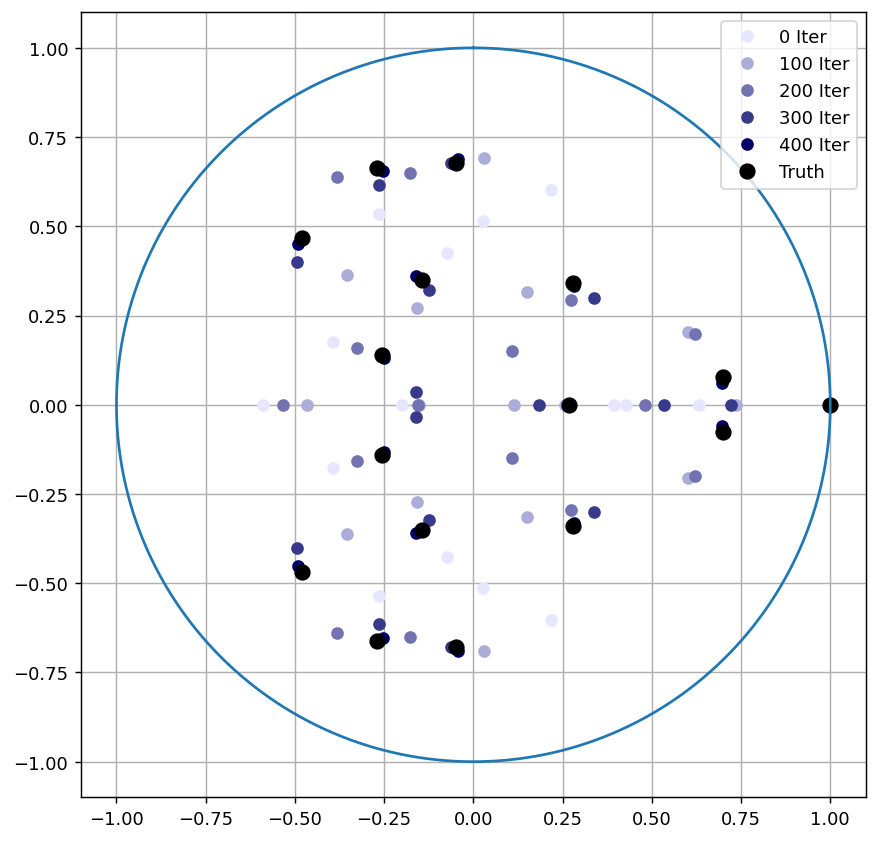

In [4]:
#spectrum_list = np.array([spectrum1, spectrum2, spectrum3, spectrum4, spectrum5, spectrum6, spectrum7])
#print(spectrum_list.shape)
t = np.linspace(0, 2*np.pi, 1000)
circle = [np.sin(t), np.cos(t)]
      
fig = plt.figure(figsize=(12,8), dpi = 130, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

a = np.linspace(0.9, 0, 5)
b = np.linspace(1, 0.4, 5)

c = list(zip(a, a, b))

plt.plot(spectrum1[0], spectrum1[1], "o", color = c[0], markersize=6)
plt.plot(spectrum2[0], spectrum2[1], "o", color = c[1], markersize=6)
plt.plot(spectrum3[0], spectrum3[1], "o", color = c[2], markersize=6)
plt.plot(spectrum4[0], spectrum4[1], "o", color = c[3], markersize=6)
plt.plot(spectrum5[0], spectrum5[1], "o", color = c[4], markersize=6)



plt.plot(spectrum[0], spectrum[1], "ko", markersize=8)
plt.legend(["0 Iter", "100 Iter", "200 Iter", "300 Iter", "400 Iter", "Truth"], loc="upper right")
plt.plot(*circle)
plt.grid()

plt.show()

In [40]:
def greedy_pair_distance(a_list, b_list):
    connections = []
    not_connected = len(a_list)*[True]
    
    for i, a in enumerate(a_list):
        min_dist = float("inf")
        idx = 0
        for j, b in enumerate(b_list):
            dist = np.linalg.norm(a - b)
            if (dist < min_dist) and not_connected[j]:
                
                min_dist = dist
                idx = j
                
        not_connected[idx] = False     
        connections.append(idx)
    
    return connections
    
    
def pair_distance(a_list, 
                  b_list, 
                  connections):
    distance = 0
    for i, idx in enumerate(connections):
        distance += np.linalg.norm(a_list[i] - b_list[idx]) 

    return distance 


def min_pair_distance(a_list = None,
                      b_list = None,
                      connections = None,
                      num_iter = 100,
                      T = 1):
    
    length = len(a_list)
    if connections is None:
        connections = greedy_pair_distance(a_list, b_list)

    distance = pair_distance(a_list, b_list, connections)
    distance_list = [distance]
    
    for i in range(num_iter):
        idx1 = random.randint(0, length-1)
        idx2 = random.randint(0, length-2)
        if idx1 <= idx2:
            idx2 += 1
        
        distance_old = np.linalg.norm(a_list[idx1] - b_list[connections[idx1]]) \
                     + np.linalg.norm(a_list[idx2] - b_list[connections[idx2]])
        distance_new = np.linalg.norm(a_list[idx2] - b_list[connections[idx1]]) \
                     + np.linalg.norm(a_list[idx1] - b_list[connections[idx2]])
        distance_diff = distance_new - distance_old
        
        
        u = random.uniform(0,1)
        if np.exp(-distance_diff/T) > u:
            distance += distance_diff
            connections[idx1], connections[idx2] = connections[idx2], connections[idx1]
        
        distance_list.append(distance)
        
    return connections, distance_list

In [3]:
#T = 0
random.seed(42)
np.random.seed(42)
n = 16
a_list = [np.random.normal(0, 1, 2) for i in range(n)]
b_list = [np.random.normal(0, 1, 2) for i in range(n)]
connections1, distance_list1 = min_pair_distance(a_list, b_list, num_iter = 1000, T = 0)

#T = 0.1
random.seed(42)
np.random.seed(42)
n = 16
a_list = [np.random.normal(0, 1, 2) for i in range(n)]
b_list = [np.random.normal(0, 1, 2) for i in range(n)]
connections2, distance_list2 = min_pair_distance(a_list, b_list, num_iter = 1000, T = 0.1)

<ipython-input-2-4c5be20463e9>:51: RuntimeWarning: divide by zero encountered in double_scalars
  if np.exp(-distance_diff/T) > u:


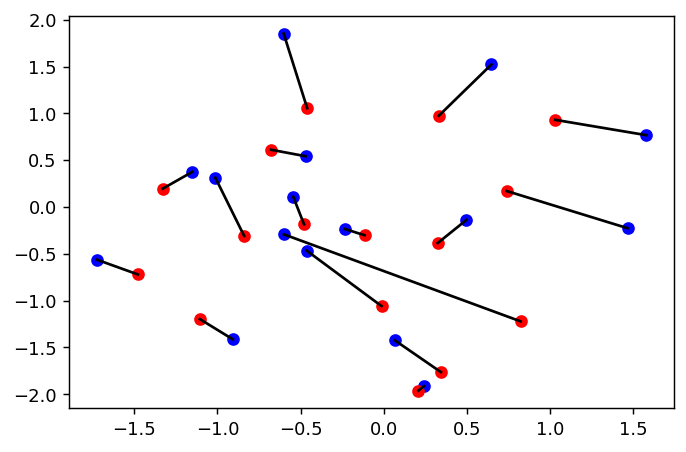

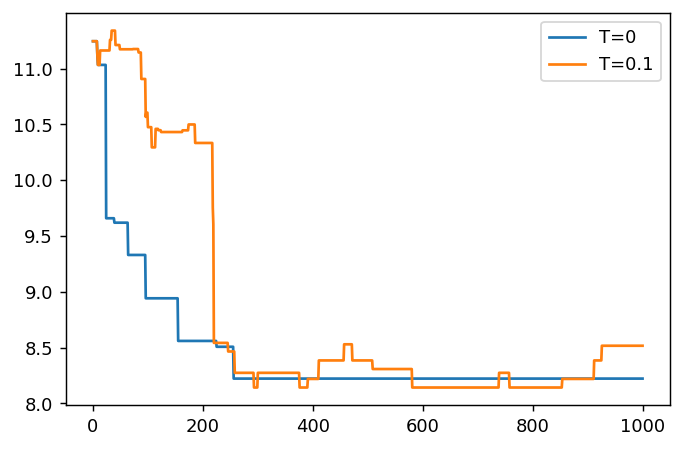

In [61]:
fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(*list(zip(*a_list)), "bo")
plt.plot(*list(zip(*b_list)), "ro")
for i in range(n):
    coords = list(zip(a_list[i], b_list[connections1[i]]))
    plt.plot(*coords, "k")
plt.show()

fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(distance_list1)
plt.plot(distance_list2)
#plt.ylim([40, 80])
plt.legend(["T=0", "T=0.1"])
plt.show()

In [62]:
n = 1
d = 2**n
rank = 2

np.random.seed(42)
choi1 = ChoiMap(d, rank)
choi2 = ChoiMap(d, rank)

spectrum1 = choi_spectrum(choi1.choi)
spectrum2 = choi_spectrum(choi2.choi)


spectrum1 = [np.array((a,b)) for a,b in zip(*spectrum1)]
spectrum2 = [np.array((a,b)) for a,b in zip(*spectrum2)]
N = len(spectrum1)

In [63]:
connections, distance_list = min_pair_distance(spectrum1, spectrum2, num_iter = 10000, T = 0.01)

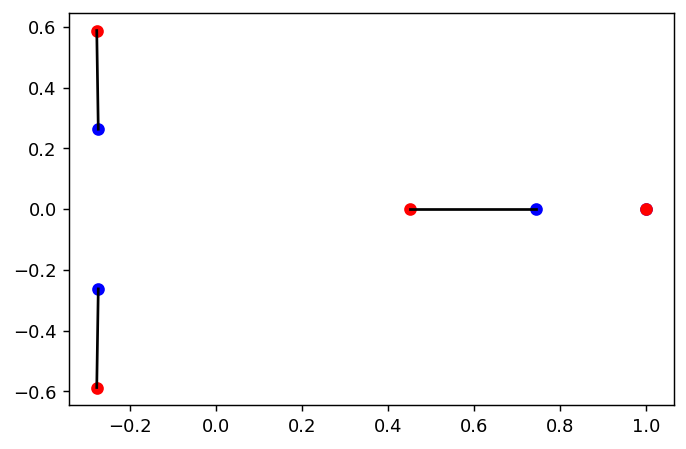

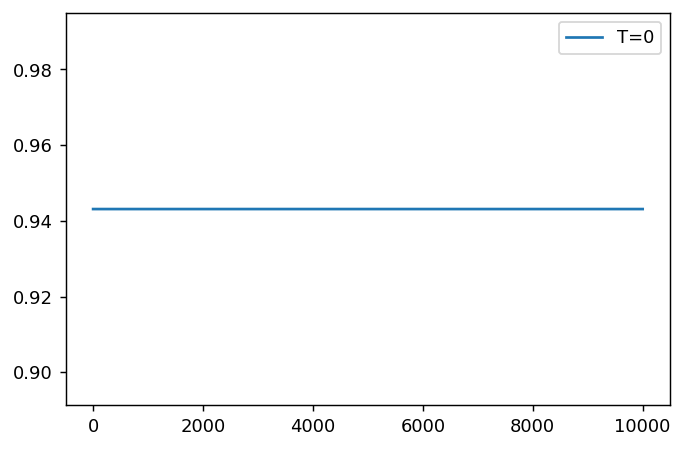

In [64]:
fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(*list(zip(*spectrum1)), "bo")
plt.plot(*list(zip(*spectrum2)), "ro")

for i in range(N):
    coords = list(zip(spectrum1[i], spectrum2[connections[i]]))
    plt.plot(*coords, "k")
plt.show()

fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(distance_list)
plt.legend(["T=0", "T=0.1"])
plt.show()

## Fit Model to Spectrum

In [41]:
class SpectrumDistance():
    
    def __init__(self, num_iter = 1000, T = 0):
        self.num_iter = num_iter
        self.T = T
        self.connections = None
        
    def __call__(self, q_map, input, target, grad=False):    
        choi_model = maps_to_choi([q_map])
    
        q_map_target = input
        choi_target = maps_to_choi([q_map_target])
    
        spectrum_model = [np.array((a,b)) for a,b in zip(*choi_spectrum(choi_model))]
        spectrum_target = [np.array((a,b)) for a,b in zip(*choi_spectrum(choi_target))]
    
        if grad:
            num_iter = 0
        else:   
            self.connections = greedy_pair_distance(spectrum_model, spectrum_target)
            num_iter = self.num_iter
        
        self.connections, distance_list = min_pair_distance(spectrum_model, 
                                                            spectrum_target,
                                                            self.connections,
                                                            num_iter = num_iter, 
                                                            T = self.T)
        
        cost = distance_list[-1]
    
        return cost

### Choi Model

### Two Qubits

In [53]:
n = 2
d = 2**n
rank = 2

np.random.seed(42)
random.seed(42)
choi_target = ChoiMap(d, rank)
spectrum_target = choi_spectrum(choi_target.choi)

choi_model = ChoiMap(d, rank)


input_list = [choi_target]
target_list = [None]

model = ModelQuantumMap(q_map = choi_model,
                        cost = SpectrumDistance(num_iter = 100000,
                                                T = 0.),
                        input_list = input_list,
                        target_list = target_list,
                        lr = 0.04, 
                        h = 1e-3)

<ipython-input-40-1f09baa54230>:58: RuntimeWarning: divide by zero encountered in double_scalars
  if np.exp(-distance_diff/T) > u:


0: fid: 2.488, c: 0.000

64
16


IndexError: list index out of range

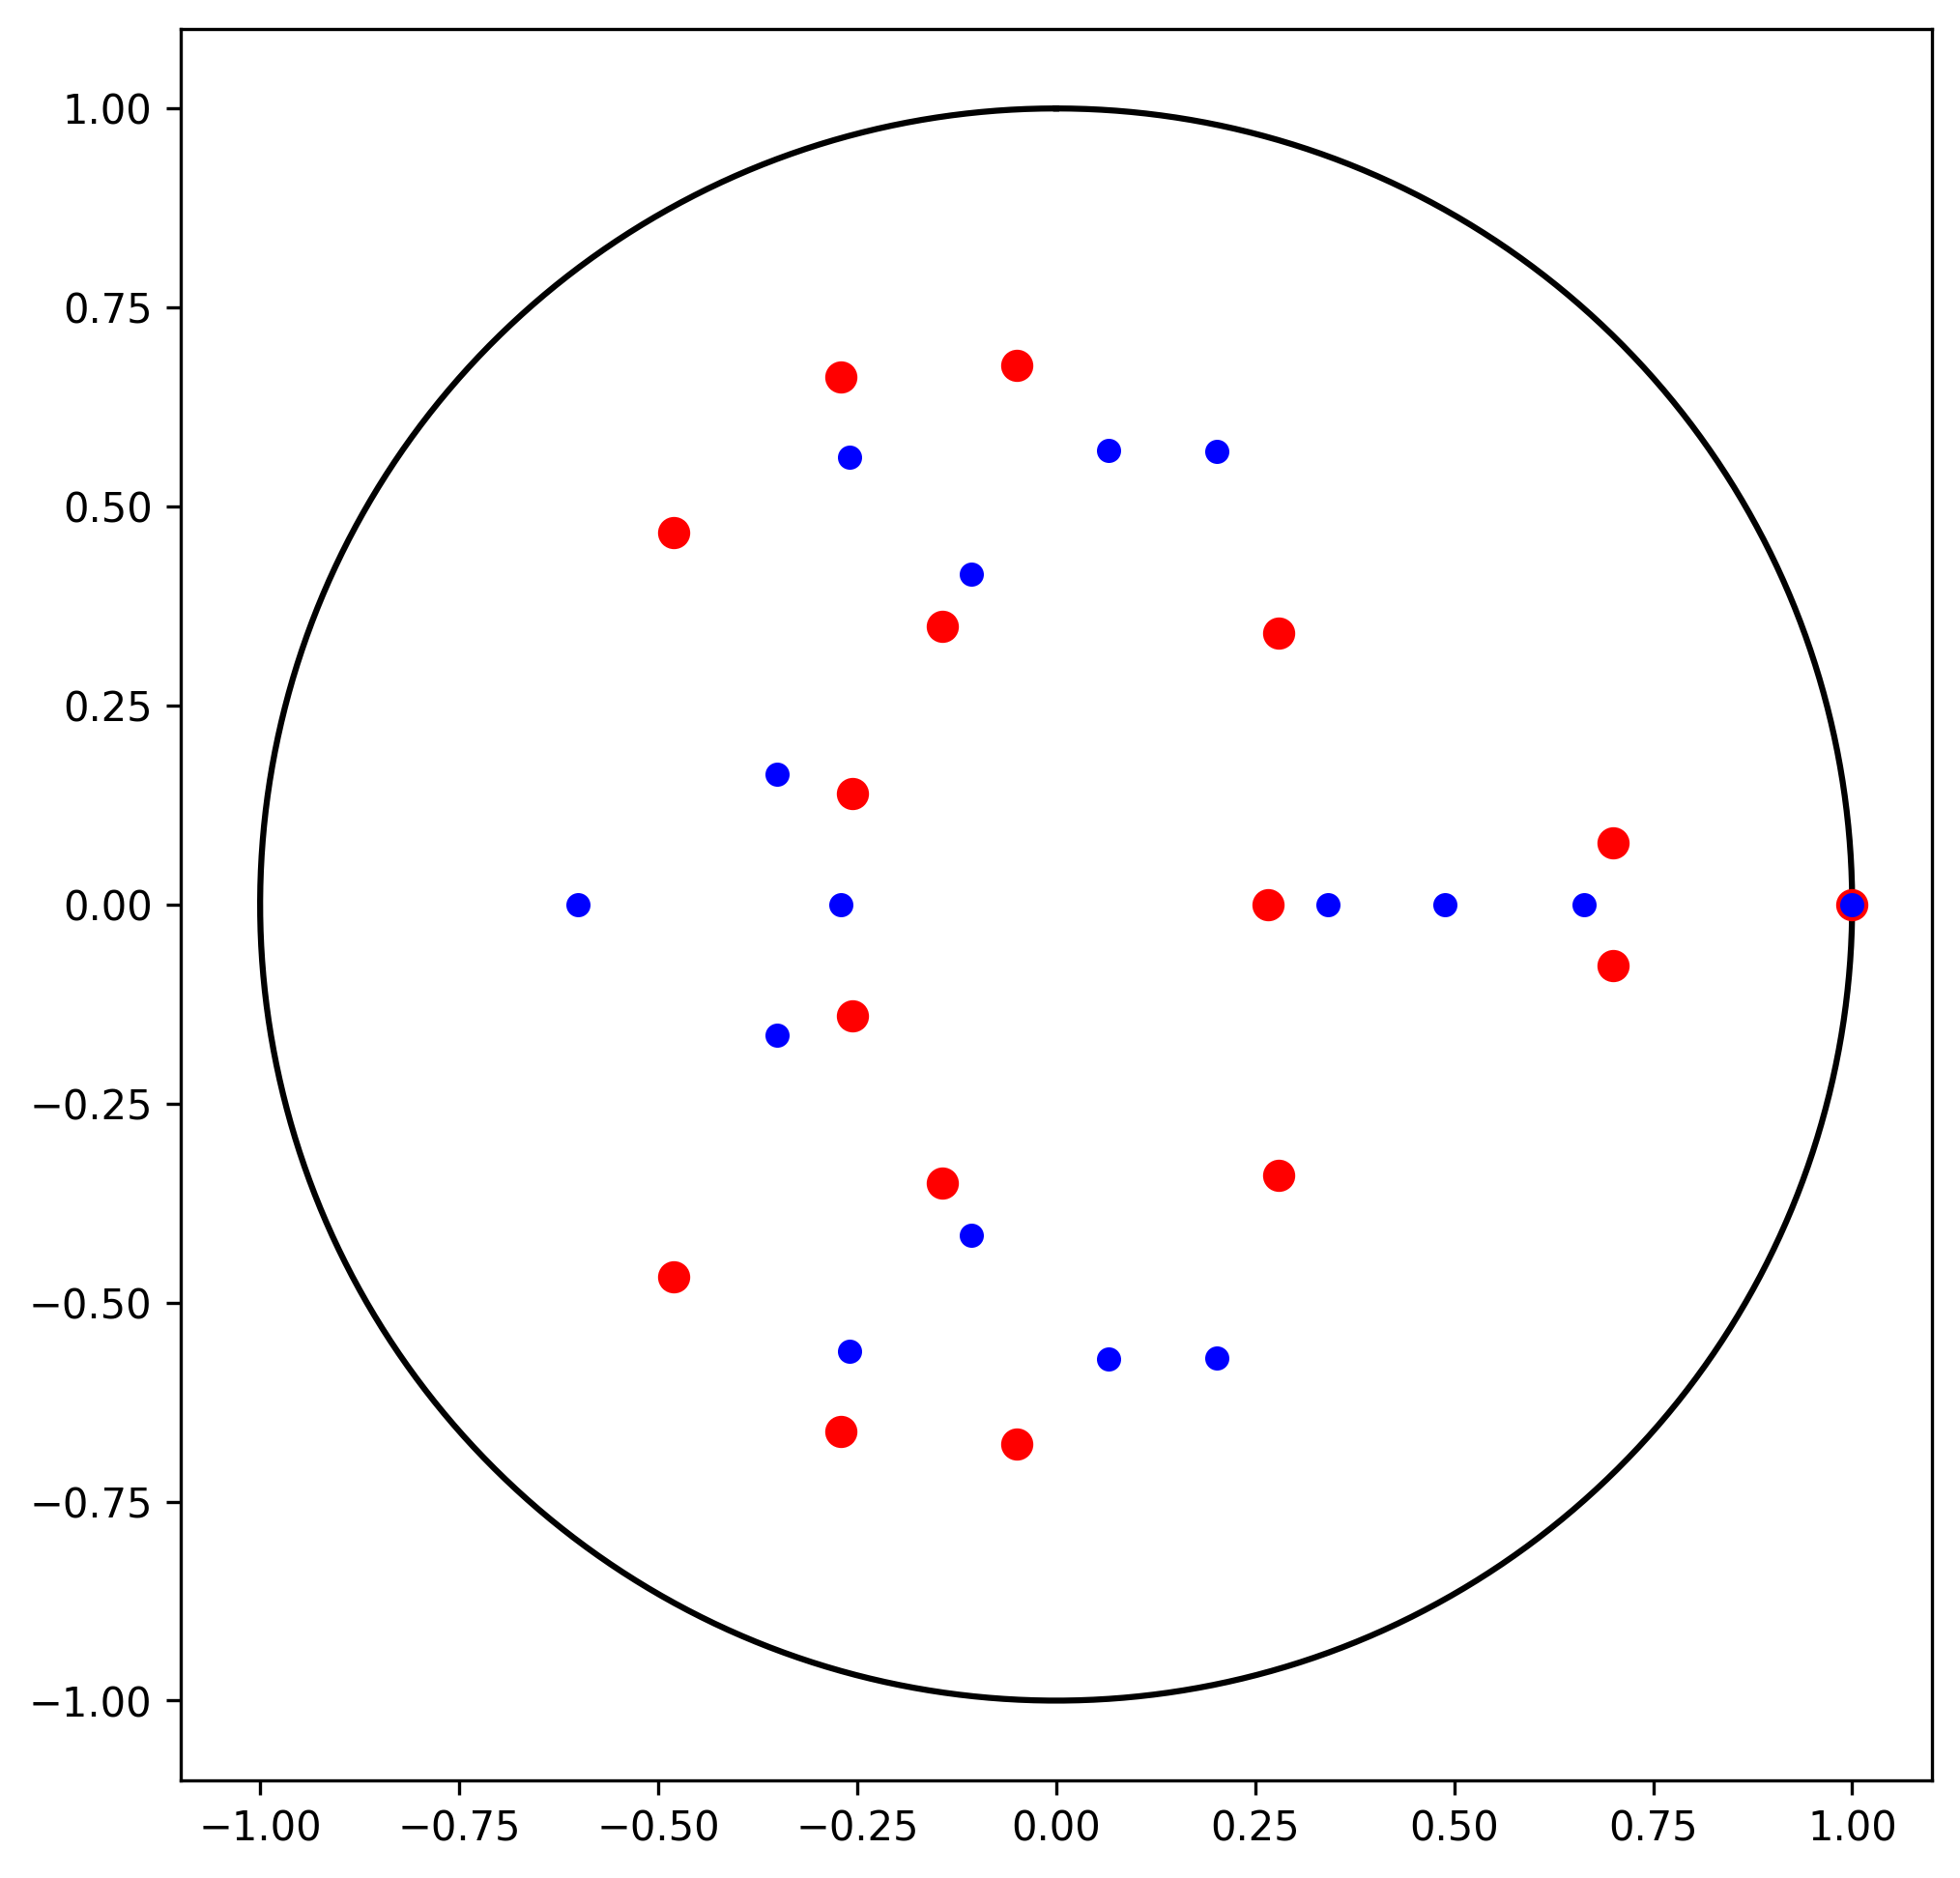

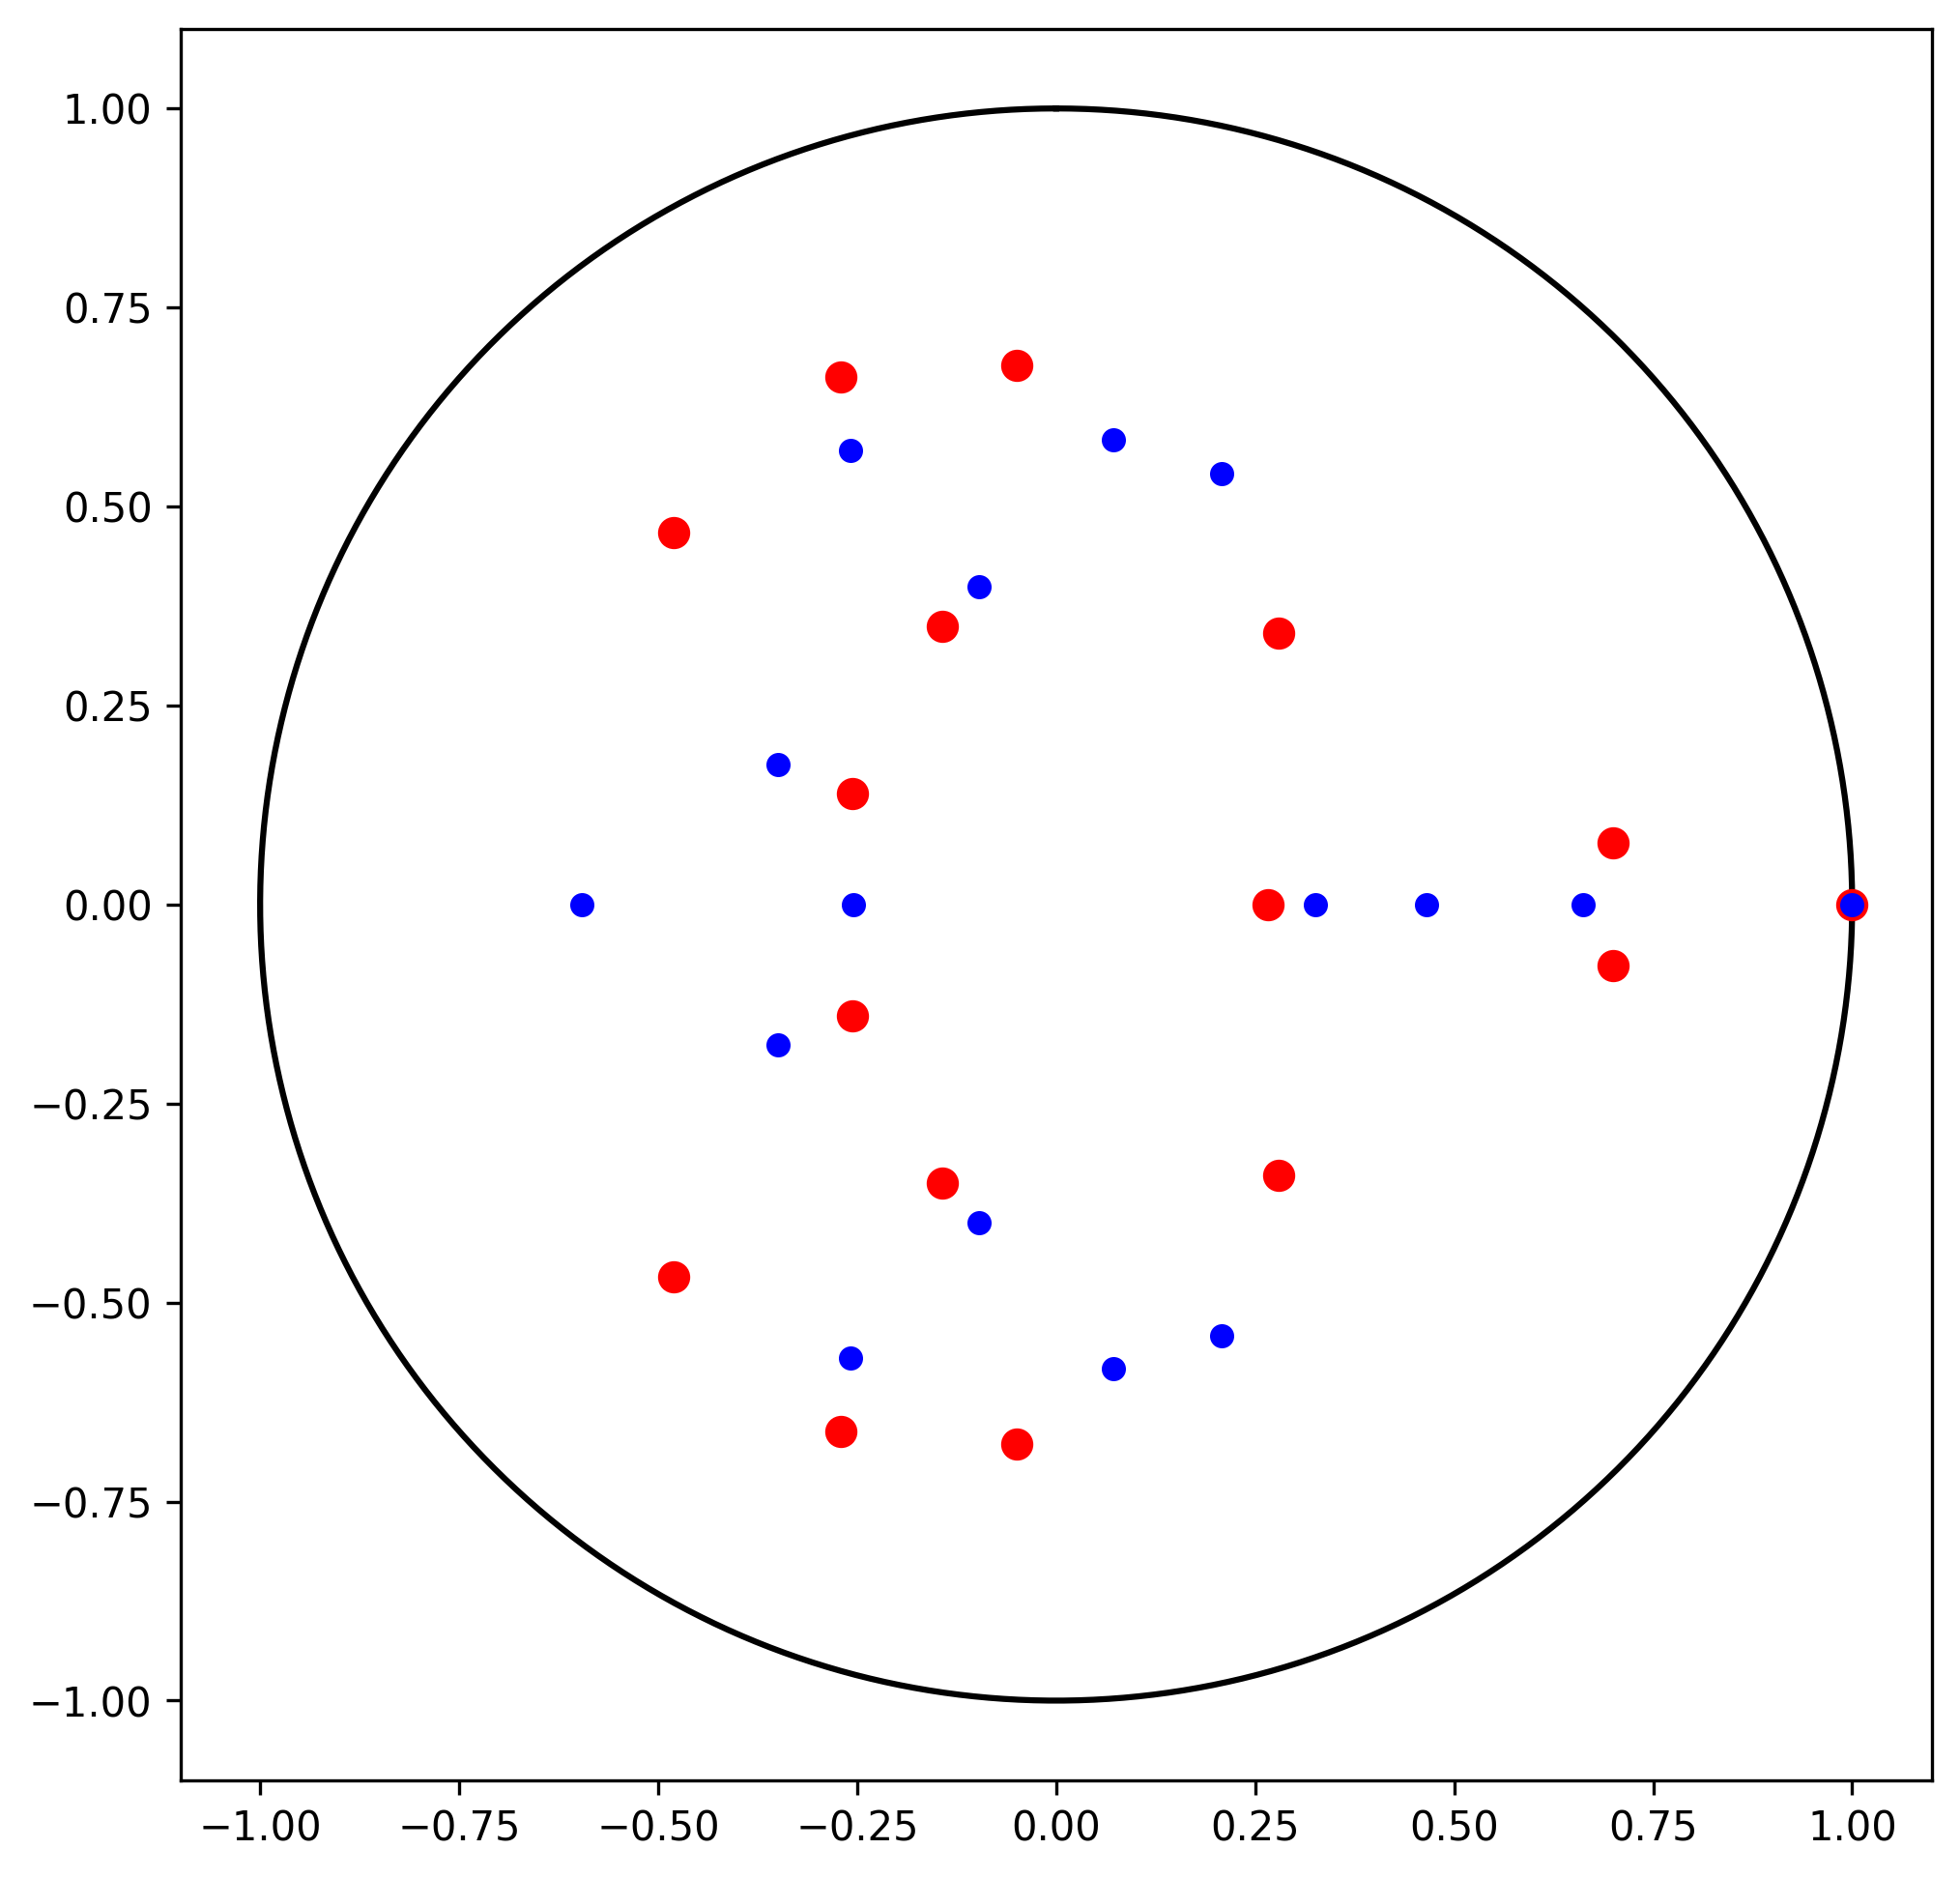

In [56]:
t = np.linspace(0, 2*np.pi, 1000)
circle = [np.sin(t), np.cos(t)]

spectrum_model = choi_spectrum(choi_model.choi)
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k-")
plt.plot(*spectrum_target, "ro", markersize = 7)
plt.plot(*spectrum_model, "bo", markersize = 5)
fig.savefig(f"spectrum_fig0.png")

for i in range(1, 101):
    model.train(num_iter = 1,
                use_adam = True,
                verbose = True)

    spectrum_model = choi_spectrum(choi_model.choi)
    
    fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    plt.plot(*circle, "k-")
    plt.plot(*spectrum_target, "ro", markersize = 7)
    plt.plot(*spectrum_model, "bo", markersize = 5)
    
    spectrum_target_points = [np.array([a,b]) for a, b in zip(*spectrum_target)]
    spectrum_model_points = [np.array([a,b]) for a, b in zip(*spectrum_model)]
    print(len(connections))
    print(len(spectrum_target_points))
    for j in range(len(spectrum_target_points)):
        coords = list(zip(spectrum_target_points[j], spectrum_model_points[connections[j]]))
        plt.plot(*coords, "k")
        
    fig.savefig(f"spectrum_fig{i}.png")
    plt.close(fig)

In [ ]:
frames = []
imgs = glob.glob("*.png")
imgs = sorted(imgs, key=lambda name: int(name[12:-4]))

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
    
frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=1, loop=0)

#### Three Qubits

In [57]:
n = 3
d = 2**n
rank = 2

np.random.seed(42)
random.seed(42)
choi_target = ChoiMap(d, rank)
spectrum_target = choi_spectrum(choi_target.choi)

choi_model = ChoiMap(d, rank)


input_list = [choi_target]
target_list = [None]

model = ModelQuantumMap(q_map = choi_model,
                        cost = SpectrumDistance(num_iter = 10000, 
                                                T = 0.0),
                        input_list = input_list,
                        target_list = target_list,
                        lr = 0.04, 
                        h = 1e-3)

<ipython-input-40-1f09baa54230>:58: RuntimeWarning: divide by zero encountered in double_scalars
  if np.exp(-distance_diff/T) > u:


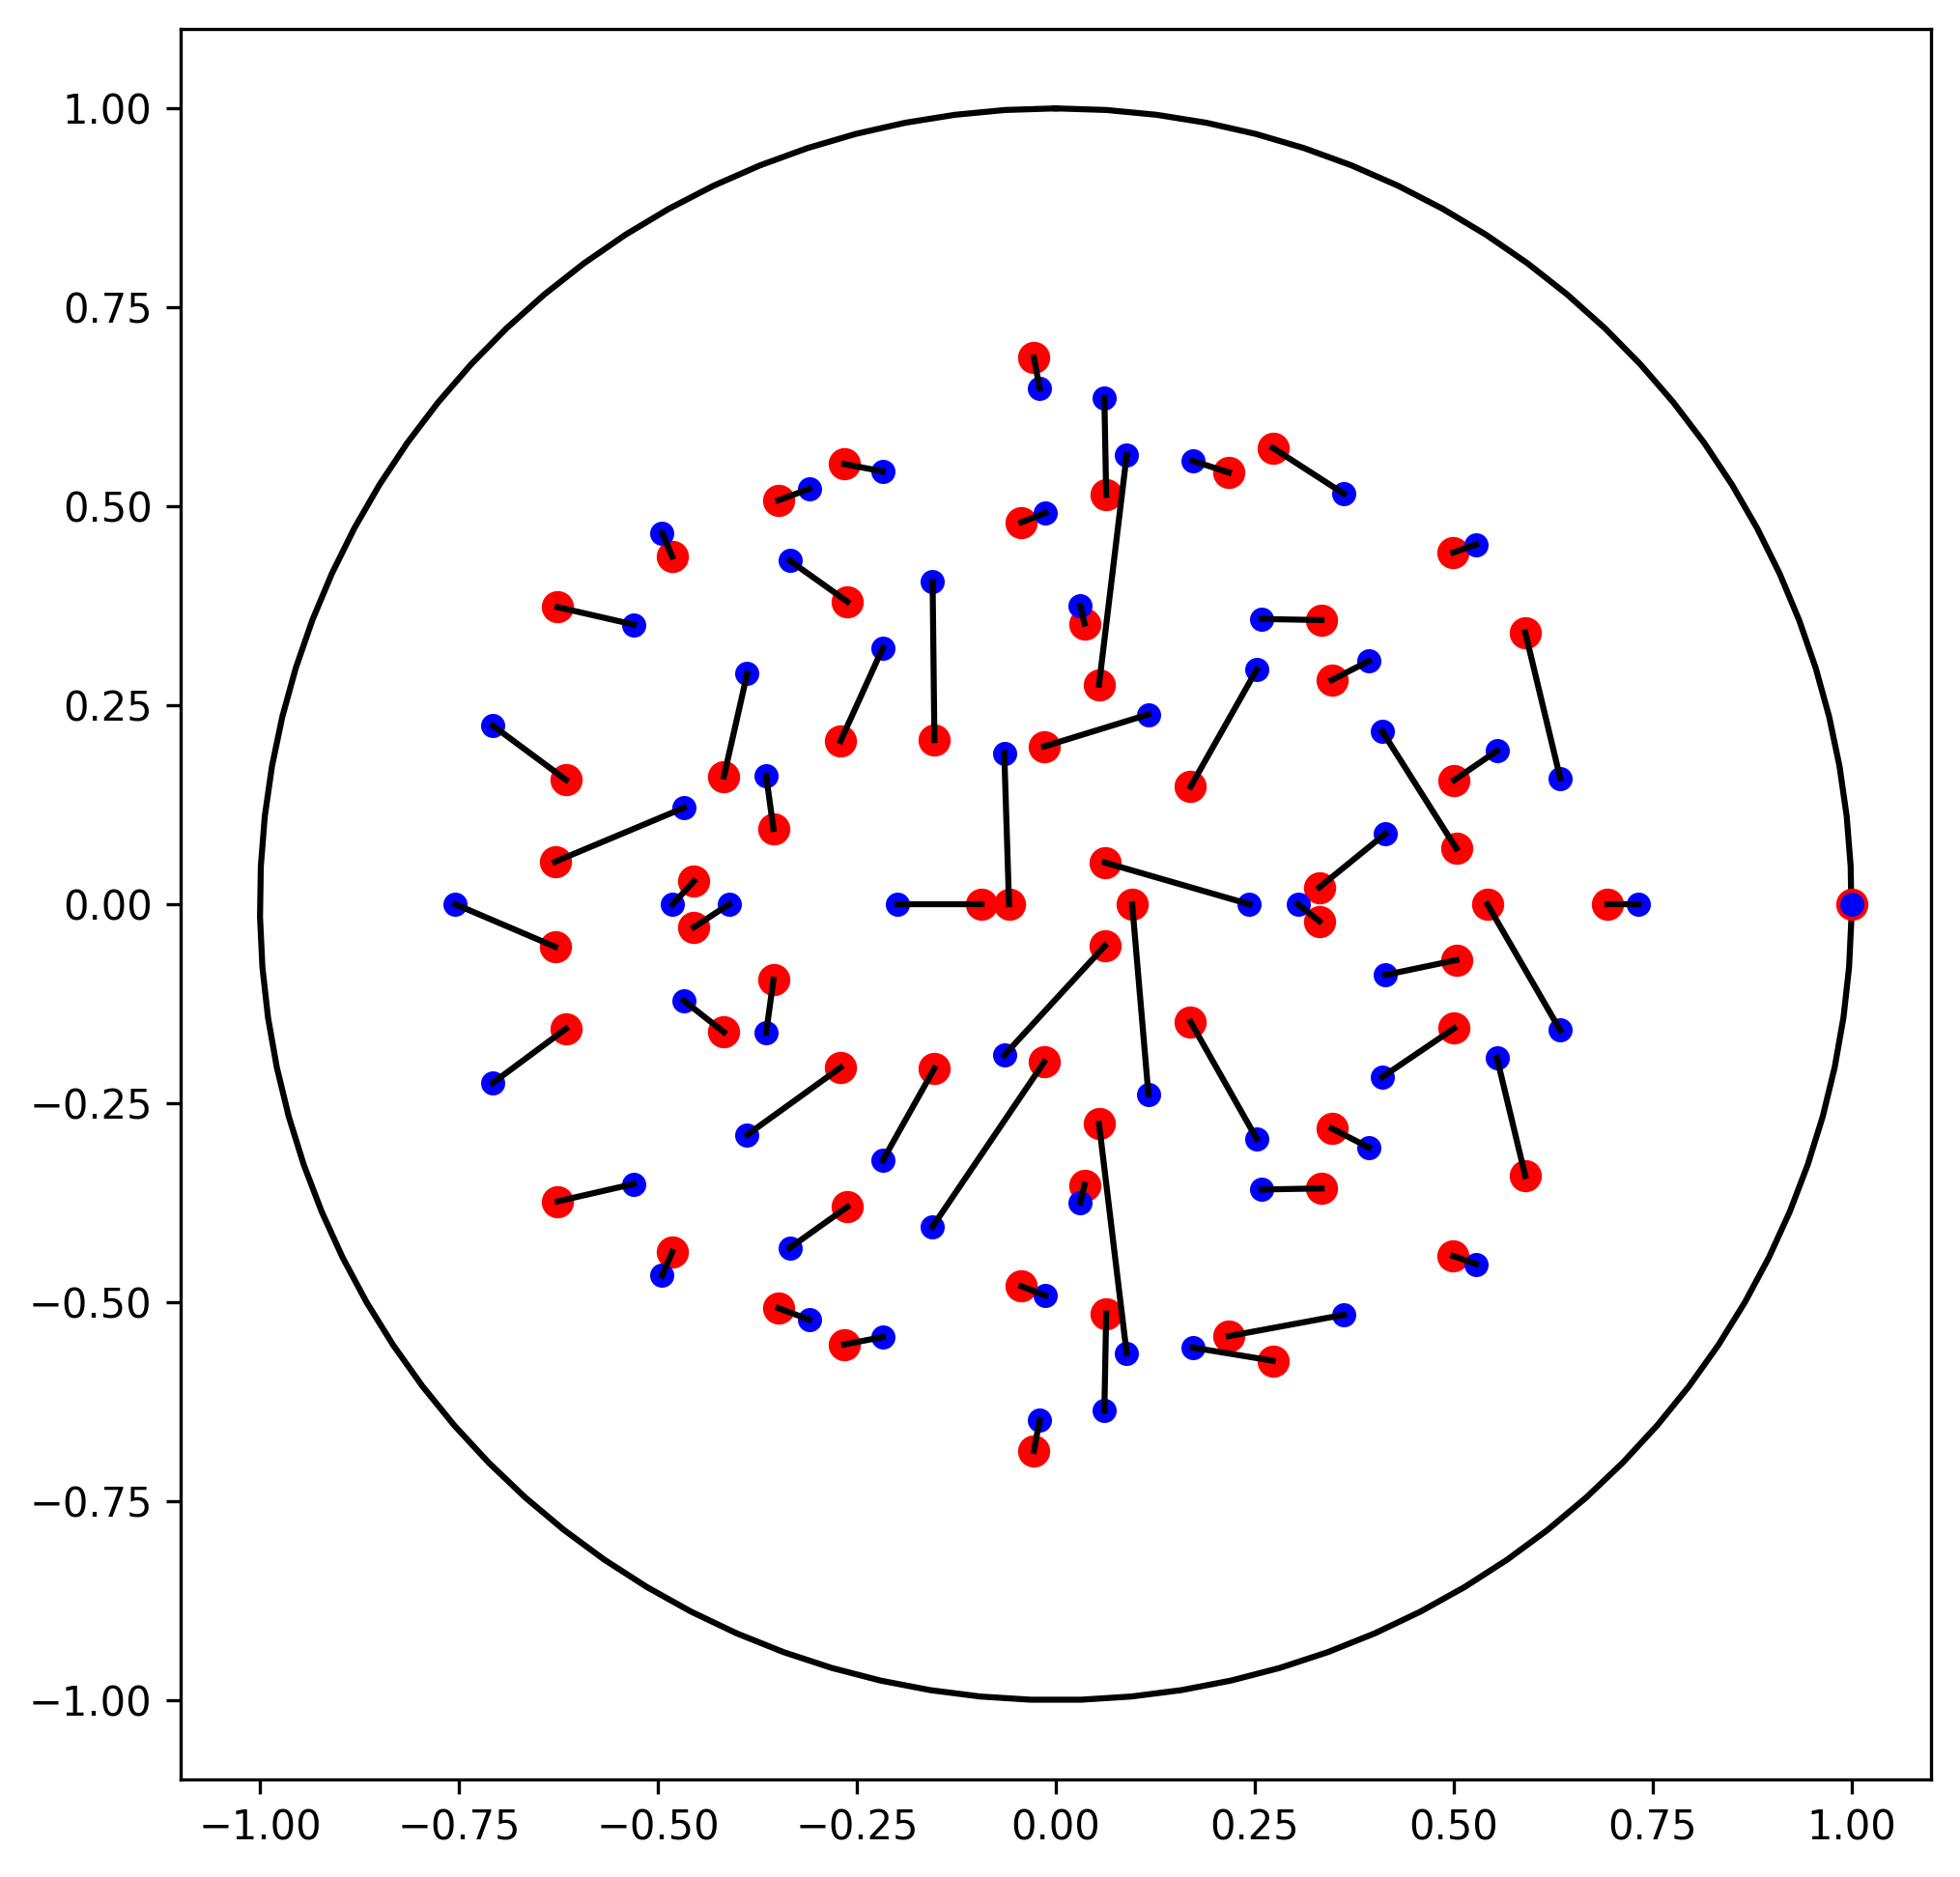

In [58]:
spectrum_model = choi_spectrum(choi_model.choi)
spectrum_target_points = [np.array([a,b]) for a, b in zip(*spectrum_target)]
spectrum_model_points = [np.array([a,b]) for a, b in zip(*spectrum_model)]
n = len(spectrum_target_points)

np.random.seed(42)
random.seed(42)
connections, distance_list = min_pair_distance(spectrum_target_points, 
                                               spectrum_model_points, 
                                               num_iter = 10000, 
                                               T = 0.00)


t = np.linspace(0,2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k-")
plt.plot(*spectrum_target, "ro", markersize = 7)
plt.plot(*spectrum_model, "bo", markersize = 5)
#fig.savefig(f"spectrum_fig0.png")
for i in range(n):
    coords = list(zip(spectrum_target_points[i], spectrum_model_points[connections[i]]))
    plt.plot(*coords, "k")
plt.show()

In [ ]:
t = np.linspace(0,2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

spectrum_model = choi_spectrum(choi_model.choi)
fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k-")
plt.plot(*spectrum_target, "ro", markersize = 7)
plt.plot(*spectrum_model, "bo", markersize = 5)
fig.savefig(f"spectrum_fig0.png")

for i in range(1, 151):
    model.train(num_iter = 1,
                use_adam = True,
                verbose = True)

    spectrum_model = choi_spectrum(choi_model.choi)
    
    fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    plt.plot(*circle, "k-")
    plt.plot(*spectrum_target, "ro", markersize = 7)
    plt.plot(*spectrum_model, "bo", markersize = 5)
    fig.savefig(f"spectrum_fig{i}.png")
    plt.close(fig)

<ipython-input-5-b6a7e5b69c32>:59: RuntimeWarning: divide by zero encountered in double_scalars
  if np.exp(-distance_diff/T) > u:
<ipython-input-5-b6a7e5b69c32>:59: RuntimeWarning: invalid value encountered in double_scalars
  if np.exp(-distance_diff/T) > u:


0: fid: 6.458, c: 0.000



0: fid: 6.374, c: 0.000



0: fid: 6.558, c: 0.000



0: fid: 6.730, c: 0.000



In [ ]:
frames = []
imgs = glob.glob("*.png")
imgs = sorted(imgs, key=lambda name: int(name[12:-4]))

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
    
frames[0].save('png_to_gif2.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=1, loop=0)